<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:55:25] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


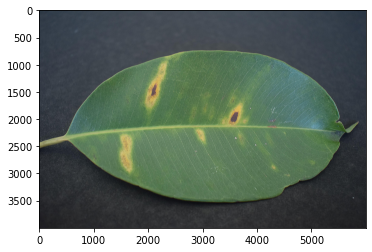

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

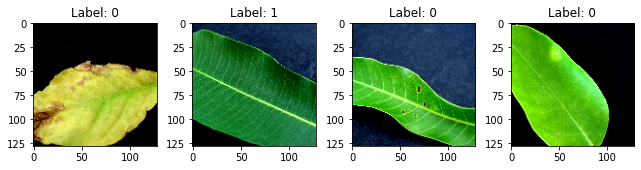

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:55:30] /work/mxnet/src/storage/storage.cc:205: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:55:32] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:107: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.248889063573791 samples/sec                   batch loss = 0.34759777784347534 | accuracy = 0.75


Epoch[1] Batch[10] Speed: 1.263235186711994 samples/sec                   batch loss = 0.46430304646492004 | accuracy = 0.7


Epoch[1] Batch[15] Speed: 1.2686755951987103 samples/sec                   batch loss = 0.5612000226974487 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2737754371243855 samples/sec                   batch loss = 0.5604939460754395 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.268497659014194 samples/sec                   batch loss = 0.5150436162948608 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.267045534358265 samples/sec                   batch loss = 1.159132480621338 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2696058960050496 samples/sec                   batch loss = 0.6161465048789978 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2687187678348655 samples/sec                   batch loss = 0.4850168824195862 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.2620981613414162 samples/sec                   batch loss = 0.3686460852622986 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2608743848741513 samples/sec                   batch loss = 1.1167455911636353 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2625894965525888 samples/sec                   batch loss = 0.5309106707572937 | accuracy = 0.6363636363636364


Epoch[1] Batch[60] Speed: 1.2610181517531662 samples/sec                   batch loss = 0.5742711424827576 | accuracy = 0.6333333333333333


Epoch[1] Batch[65] Speed: 1.2641134219961945 samples/sec                   batch loss = 0.6869831681251526 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2623393645496903 samples/sec                   batch loss = 0.896134614944458 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2613649571959429 samples/sec                   batch loss = 0.5048850178718567 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2637106547356 samples/sec                   batch loss = 0.6760226488113403 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2579218741377531 samples/sec                   batch loss = 0.41326555609703064 | accuracy = 0.638235294117647


Epoch[1] Batch[90] Speed: 1.2610131283628996 samples/sec                   batch loss = 0.5518997311592102 | accuracy = 0.65


Epoch[1] Batch[95] Speed: 1.259092297474268 samples/sec                   batch loss = 0.45668667554855347 | accuracy = 0.65


Epoch[1] Batch[100] Speed: 1.2527851466412543 samples/sec                   batch loss = 0.2967763841152191 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2605375093551086 samples/sec                   batch loss = 0.16827605664730072 | accuracy = 0.6595238095238095


Epoch[1] Batch[110] Speed: 1.2582964219301511 samples/sec                   batch loss = 0.5910142064094543 | accuracy = 0.6613636363636364


Epoch[1] Batch[115] Speed: 1.2643344341198453 samples/sec                   batch loss = 0.3381516635417938 | accuracy = 0.6695652173913044


Epoch[1] Batch[120] Speed: 1.26834086715236 samples/sec                   batch loss = 0.8083832263946533 | accuracy = 0.6625


Epoch[1] Batch[125] Speed: 1.2653438788109255 samples/sec                   batch loss = 0.3570677936077118 | accuracy = 0.666


Epoch[1] Batch[130] Speed: 1.2703791113200325 samples/sec                   batch loss = 0.5160657167434692 | accuracy = 0.6673076923076923


Epoch[1] Batch[135] Speed: 1.2666575363605381 samples/sec                   batch loss = 0.6211360096931458 | accuracy = 0.6611111111111111


Epoch[1] Batch[140] Speed: 1.2696720001991855 samples/sec                   batch loss = 0.5465751886367798 | accuracy = 0.6589285714285714


Epoch[1] Batch[145] Speed: 1.263968567615157 samples/sec                   batch loss = 0.3938124179840088 | accuracy = 0.6603448275862069


Epoch[1] Batch[150] Speed: 1.2681841140460561 samples/sec                   batch loss = 0.6546039581298828 | accuracy = 0.6583333333333333


Epoch[1] Batch[155] Speed: 1.267618208012737 samples/sec                   batch loss = 0.8367719650268555 | accuracy = 0.6612903225806451


Epoch[1] Batch[160] Speed: 1.2611157840773872 samples/sec                   batch loss = 0.8433810472488403 | accuracy = 0.6609375


Epoch[1] Batch[165] Speed: 1.2598202122961586 samples/sec                   batch loss = 0.32827895879745483 | accuracy = 0.6636363636363637


Epoch[1] Batch[170] Speed: 1.2606178277783935 samples/sec                   batch loss = 0.33765608072280884 | accuracy = 0.6602941176470588


Epoch[1] Batch[175] Speed: 1.268408949376717 samples/sec                   batch loss = 0.7771894931793213 | accuracy = 0.66


Epoch[1] Batch[180] Speed: 1.2567620034132967 samples/sec                   batch loss = 0.5829746723175049 | accuracy = 0.6638888888888889


Epoch[1] Batch[185] Speed: 1.262927945231321 samples/sec                   batch loss = 0.26899757981300354 | accuracy = 0.6675675675675675


Epoch[1] Batch[190] Speed: 1.2628970486813935 samples/sec                   batch loss = 0.6171554327011108 | accuracy = 0.6697368421052632


Epoch[1] Batch[195] Speed: 1.2689004129072972 samples/sec                   batch loss = 0.3803398609161377 | accuracy = 0.6705128205128205


Epoch[1] Batch[200] Speed: 1.2599800142120492 samples/sec                   batch loss = 0.6680583357810974 | accuracy = 0.67125


Epoch[1] Batch[205] Speed: 1.26459574725325 samples/sec                   batch loss = 0.7419940233230591 | accuracy = 0.6682926829268293


Epoch[1] Batch[210] Speed: 1.2615645183776085 samples/sec                   batch loss = 0.5852357149124146 | accuracy = 0.6678571428571428


Epoch[1] Batch[215] Speed: 1.2529422329895883 samples/sec                   batch loss = 0.26247501373291016 | accuracy = 0.6686046511627907


Epoch[1] Batch[220] Speed: 1.2530968316858748 samples/sec                   batch loss = 0.5032845735549927 | accuracy = 0.6670454545454545


Epoch[1] Batch[225] Speed: 1.2587478737285887 samples/sec                   batch loss = 0.8079712986946106 | accuracy = 0.67


Epoch[1] Batch[230] Speed: 1.2598210637087146 samples/sec                   batch loss = 0.44088003039360046 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.2553607486364207 samples/sec                   batch loss = 0.31225746870040894 | accuracy = 0.6702127659574468


Epoch[1] Batch[240] Speed: 1.259585266413081 samples/sec                   batch loss = 0.4581383466720581 | accuracy = 0.671875


Epoch[1] Batch[245] Speed: 1.2555312597964339 samples/sec                   batch loss = 0.3611069917678833 | accuracy = 0.6744897959183673


Epoch[1] Batch[250] Speed: 1.2583236018327473 samples/sec                   batch loss = 0.579301118850708 | accuracy = 0.675


Epoch[1] Batch[255] Speed: 1.2633414389858821 samples/sec                   batch loss = 0.4011346697807312 | accuracy = 0.6754901960784314


Epoch[1] Batch[260] Speed: 1.2598392274507302 samples/sec                   batch loss = 0.5214111804962158 | accuracy = 0.6740384615384616


Epoch[1] Batch[265] Speed: 1.2600836374722133 samples/sec                   batch loss = 0.30988314747810364 | accuracy = 0.6735849056603773


Epoch[1] Batch[270] Speed: 1.2593607120847379 samples/sec                   batch loss = 0.5477191805839539 | accuracy = 0.674074074074074


Epoch[1] Batch[275] Speed: 1.2571997306238656 samples/sec                   batch loss = 0.9822942018508911 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.2624048091909894 samples/sec                   batch loss = 0.4841610789299011 | accuracy = 0.675


Epoch[1] Batch[285] Speed: 1.263175932911969 samples/sec                   batch loss = 0.4183976948261261 | accuracy = 0.6763157894736842


Epoch[1] Batch[290] Speed: 1.2693096646733886 samples/sec                   batch loss = 0.506351888179779 | accuracy = 0.6775862068965517


Epoch[1] Batch[295] Speed: 1.2568709358424979 samples/sec                   batch loss = 0.3090207278728485 | accuracy = 0.6779661016949152


Epoch[1] Batch[300] Speed: 1.2686512279413338 samples/sec                   batch loss = 0.6258156299591064 | accuracy = 0.68


Epoch[1] Batch[305] Speed: 1.2624524959170418 samples/sec                   batch loss = 0.33639445900917053 | accuracy = 0.680327868852459


Epoch[1] Batch[310] Speed: 1.2612411168481963 samples/sec                   batch loss = 0.3458288311958313 | accuracy = 0.6790322580645162


Epoch[1] Batch[315] Speed: 1.268200506593356 samples/sec                   batch loss = 0.30977803468704224 | accuracy = 0.6817460317460318


Epoch[1] Batch[320] Speed: 1.2599900445771033 samples/sec                   batch loss = 0.5436958074569702 | accuracy = 0.6828125


Epoch[1] Batch[325] Speed: 1.2669491823008188 samples/sec                   batch loss = 0.4159216284751892 | accuracy = 0.6838461538461539


Epoch[1] Batch[330] Speed: 1.269076158188227 samples/sec                   batch loss = 0.23548102378845215 | accuracy = 0.6848484848484848


Epoch[1] Batch[335] Speed: 1.263053638472885 samples/sec                   batch loss = 0.39473336935043335 | accuracy = 0.6865671641791045


Epoch[1] Batch[340] Speed: 1.2643363397327558 samples/sec                   batch loss = 0.41841942071914673 | accuracy = 0.6889705882352941


Epoch[1] Batch[345] Speed: 1.2651231814606831 samples/sec                   batch loss = 1.7026845216751099 | accuracy = 0.6891304347826087


Epoch[1] Batch[350] Speed: 1.2642702183232497 samples/sec                   batch loss = 1.0341476202011108 | accuracy = 0.6885714285714286


Epoch[1] Batch[355] Speed: 1.2642307774327652 samples/sec                   batch loss = 0.963405966758728 | accuracy = 0.6894366197183098


Epoch[1] Batch[360] Speed: 1.268640099898923 samples/sec                   batch loss = 0.5029090046882629 | accuracy = 0.6895833333333333


Epoch[1] Batch[365] Speed: 1.2661283445334102 samples/sec                   batch loss = 0.8434732556343079 | accuracy = 0.6863013698630137


Epoch[1] Batch[370] Speed: 1.2722245717036844 samples/sec                   batch loss = 0.11965415626764297 | accuracy = 0.6864864864864865


Epoch[1] Batch[375] Speed: 1.2662037388189733 samples/sec                   batch loss = 0.6943694353103638 | accuracy = 0.688


Epoch[1] Batch[380] Speed: 1.263658780217792 samples/sec                   batch loss = 0.9219900965690613 | accuracy = 0.6901315789473684


Epoch[1] Batch[385] Speed: 1.2665366703581995 samples/sec                   batch loss = 1.1301192045211792 | accuracy = 0.688961038961039


Epoch[1] Batch[390] Speed: 1.266359238023409 samples/sec                   batch loss = 0.8171017169952393 | accuracy = 0.6891025641025641


Epoch[1] Batch[395] Speed: 1.268730856699538 samples/sec                   batch loss = 0.6092483401298523 | accuracy = 0.6886075949367089


Epoch[1] Batch[400] Speed: 1.2680503053575778 samples/sec                   batch loss = 0.1508619636297226 | accuracy = 0.690625


Epoch[1] Batch[405] Speed: 1.2747457778436277 samples/sec                   batch loss = 0.5850690603256226 | accuracy = 0.6888888888888889


Epoch[1] Batch[410] Speed: 1.2666127826513804 samples/sec                   batch loss = 1.4464833736419678 | accuracy = 0.6884146341463414


Epoch[1] Batch[415] Speed: 1.2740470532469177 samples/sec                   batch loss = 0.6308373808860779 | accuracy = 0.6879518072289157


Epoch[1] Batch[420] Speed: 1.2688314142792028 samples/sec                   batch loss = 0.4300062656402588 | accuracy = 0.6898809523809524


Epoch[1] Batch[425] Speed: 1.2708832703025665 samples/sec                   batch loss = 0.6611970663070679 | accuracy = 0.69


Epoch[1] Batch[430] Speed: 1.268614870663744 samples/sec                   batch loss = 0.32205328345298767 | accuracy = 0.6918604651162791


Epoch[1] Batch[435] Speed: 1.270616754294193 samples/sec                   batch loss = 1.1297420263290405 | accuracy = 0.6913793103448276


Epoch[1] Batch[440] Speed: 1.2753896152222561 samples/sec                   batch loss = 0.4362533986568451 | accuracy = 0.6931818181818182


Epoch[1] Batch[445] Speed: 1.2702417615165236 samples/sec                   batch loss = 1.1714739799499512 | accuracy = 0.6932584269662921


Epoch[1] Batch[450] Speed: 1.2673409011730061 samples/sec                   batch loss = 0.22186687588691711 | accuracy = 0.695


Epoch[1] Batch[455] Speed: 1.2695573791382104 samples/sec                   batch loss = 0.5730299949645996 | accuracy = 0.695054945054945


Epoch[1] Batch[460] Speed: 1.267605469922581 samples/sec                   batch loss = 0.4711558520793915 | accuracy = 0.6945652173913044


Epoch[1] Batch[465] Speed: 1.26681840806839 samples/sec                   batch loss = 0.5576403737068176 | accuracy = 0.6924731182795699


Epoch[1] Batch[470] Speed: 1.2668985722447594 samples/sec                   batch loss = 0.42888492345809937 | accuracy = 0.6925531914893617


Epoch[1] Batch[475] Speed: 1.2634719720610383 samples/sec                   batch loss = 0.11145120114088058 | accuracy = 0.6936842105263158


Epoch[1] Batch[480] Speed: 1.2644949068501248 samples/sec                   batch loss = 1.3596023321151733 | accuracy = 0.69375


Epoch[1] Batch[485] Speed: 1.2658260931105452 samples/sec                   batch loss = 0.5101161599159241 | accuracy = 0.6932989690721649


Epoch[1] Batch[490] Speed: 1.2740845933587002 samples/sec                   batch loss = 0.7093679308891296 | accuracy = 0.6948979591836735


Epoch[1] Batch[495] Speed: 1.2679514047650537 samples/sec                   batch loss = 1.258442997932434 | accuracy = 0.6944444444444444


Epoch[1] Batch[500] Speed: 1.2726853991327312 samples/sec                   batch loss = 0.23701399564743042 | accuracy = 0.6945


Epoch[1] Batch[505] Speed: 1.2582298927484759 samples/sec                   batch loss = 0.5877203345298767 | accuracy = 0.694059405940594


Epoch[1] Batch[510] Speed: 1.25513290906093 samples/sec                   batch loss = 0.43486011028289795 | accuracy = 0.6946078431372549


Epoch[1] Batch[515] Speed: 1.2577922023885075 samples/sec                   batch loss = 0.3985566198825836 | accuracy = 0.6951456310679611


Epoch[1] Batch[520] Speed: 1.257287350347299 samples/sec                   batch loss = 0.8663754463195801 | accuracy = 0.6951923076923077


Epoch[1] Batch[525] Speed: 1.2582487655603816 samples/sec                   batch loss = 0.3288278877735138 | accuracy = 0.6966666666666667


Epoch[1] Batch[530] Speed: 1.2566405711937227 samples/sec                   batch loss = 1.0100469589233398 | accuracy = 0.6966981132075472


Epoch[1] Batch[535] Speed: 1.258204226632834 samples/sec                   batch loss = 0.6275750398635864 | accuracy = 0.6962616822429907


Epoch[1] Batch[540] Speed: 1.257424740047252 samples/sec                   batch loss = 0.6708324551582336 | accuracy = 0.6953703703703704


Epoch[1] Batch[545] Speed: 1.2648194072681889 samples/sec                   batch loss = 0.45733579993247986 | accuracy = 0.6954128440366972


Epoch[1] Batch[550] Speed: 1.2590032922621035 samples/sec                   batch loss = 0.42511582374572754 | accuracy = 0.6968181818181818


Epoch[1] Batch[555] Speed: 1.2588523334276254 samples/sec                   batch loss = 0.4070437252521515 | accuracy = 0.6981981981981982


Epoch[1] Batch[560] Speed: 1.2637940436195794 samples/sec                   batch loss = 0.5069419741630554 | accuracy = 0.6977678571428572


Epoch[1] Batch[565] Speed: 1.259501864679877 samples/sec                   batch loss = 0.3742407262325287 | accuracy = 0.6991150442477876


Epoch[1] Batch[570] Speed: 1.2624111735457044 samples/sec                   batch loss = 0.6782547235488892 | accuracy = 0.6973684210526315


Epoch[1] Batch[575] Speed: 1.2682587946382304 samples/sec                   batch loss = 0.5099619030952454 | accuracy = 0.6978260869565217


Epoch[1] Batch[580] Speed: 1.2549457029976636 samples/sec                   batch loss = 0.6320133805274963 | accuracy = 0.6987068965517241


Epoch[1] Batch[585] Speed: 1.2634976632334445 samples/sec                   batch loss = 1.8532978296279907 | accuracy = 0.6974358974358974


Epoch[1] Batch[590] Speed: 1.2557223060923117 samples/sec                   batch loss = 0.5049452185630798 | accuracy = 0.6974576271186441


Epoch[1] Batch[595] Speed: 1.2563946722422503 samples/sec                   batch loss = 0.19520598649978638 | accuracy = 0.6983193277310924


Epoch[1] Batch[600] Speed: 1.2613770959965007 samples/sec                   batch loss = 0.35947734117507935 | accuracy = 0.6991666666666667


Epoch[1] Batch[605] Speed: 1.2683084587457312 samples/sec                   batch loss = 0.4506693482398987 | accuracy = 0.6991735537190082


Epoch[1] Batch[610] Speed: 1.2587836676403725 samples/sec                   batch loss = 0.18435412645339966 | accuracy = 0.6995901639344262


Epoch[1] Batch[615] Speed: 1.259312786014835 samples/sec                   batch loss = 0.2791253328323364 | accuracy = 0.6991869918699187


Epoch[1] Batch[620] Speed: 1.2570297078367005 samples/sec                   batch loss = 1.3823755979537964 | accuracy = 0.6991935483870968


Epoch[1] Batch[625] Speed: 1.264931648428171 samples/sec                   batch loss = 0.2532733380794525 | accuracy = 0.7


Epoch[1] Batch[630] Speed: 1.2609812828953326 samples/sec                   batch loss = 0.5385024547576904 | accuracy = 0.7003968253968254


Epoch[1] Batch[635] Speed: 1.2671333834631442 samples/sec                   batch loss = 0.5617043972015381 | accuracy = 0.7


Epoch[1] Batch[640] Speed: 1.2665068398943689 samples/sec                   batch loss = 0.6334373354911804 | accuracy = 0.699609375


Epoch[1] Batch[645] Speed: 1.2656775995451255 samples/sec                   batch loss = 0.5171394944190979 | accuracy = 0.6992248062015504


Epoch[1] Batch[650] Speed: 1.2632366134370292 samples/sec                   batch loss = 0.37770023941993713 | accuracy = 0.7003846153846154


Epoch[1] Batch[655] Speed: 1.2616384213547358 samples/sec                   batch loss = 0.44878578186035156 | accuracy = 0.700381679389313


Epoch[1] Batch[660] Speed: 1.2654188933651858 samples/sec                   batch loss = 0.12869378924369812 | accuracy = 0.7003787878787879


Epoch[1] Batch[665] Speed: 1.265388638333549 samples/sec                   batch loss = 0.1485033482313156 | accuracy = 0.7007518796992481


Epoch[1] Batch[670] Speed: 1.2723526048120808 samples/sec                   batch loss = 0.9412687420845032 | accuracy = 0.7011194029850746


Epoch[1] Batch[675] Speed: 1.2673008855506898 samples/sec                   batch loss = 0.2577721178531647 | accuracy = 0.7025925925925925


Epoch[1] Batch[680] Speed: 1.2660347114071149 samples/sec                   batch loss = 0.6558573842048645 | accuracy = 0.7033088235294118


Epoch[1] Batch[685] Speed: 1.2648439136211012 samples/sec                   batch loss = 1.0113853216171265 | accuracy = 0.7036496350364964


Epoch[1] Batch[690] Speed: 1.262818245558045 samples/sec                   batch loss = 0.36694103479385376 | accuracy = 0.7036231884057971


Epoch[1] Batch[695] Speed: 1.2535949512537394 samples/sec                   batch loss = 0.5983501672744751 | accuracy = 0.7025179856115108


Epoch[1] Batch[700] Speed: 1.257231479585857 samples/sec                   batch loss = 0.44337692856788635 | accuracy = 0.7028571428571428


Epoch[1] Batch[705] Speed: 1.259510847329011 samples/sec                   batch loss = 0.3220176696777344 | accuracy = 0.7031914893617022


Epoch[1] Batch[710] Speed: 1.2663200490067172 samples/sec                   batch loss = 1.497965693473816 | accuracy = 0.703169014084507


Epoch[1] Batch[715] Speed: 1.2687061994976059 samples/sec                   batch loss = 0.4934444725513458 | accuracy = 0.7038461538461539


Epoch[1] Batch[720] Speed: 1.2656213625264123 samples/sec                   batch loss = 0.18203875422477722 | accuracy = 0.7048611111111112


Epoch[1] Batch[725] Speed: 1.262251799026099 samples/sec                   batch loss = 0.39092016220092773 | accuracy = 0.7044827586206897


Epoch[1] Batch[730] Speed: 1.2632296700721801 samples/sec                   batch loss = 0.6641889810562134 | accuracy = 0.7044520547945206


Epoch[1] Batch[735] Speed: 1.2643914144278339 samples/sec                   batch loss = 0.6295073628425598 | accuracy = 0.704421768707483


Epoch[1] Batch[740] Speed: 1.2662750324225485 samples/sec                   batch loss = 0.49295568466186523 | accuracy = 0.7047297297297297


Epoch[1] Batch[745] Speed: 1.264276220413627 samples/sec                   batch loss = 0.6863665580749512 | accuracy = 0.7046979865771812


Epoch[1] Batch[750] Speed: 1.2684156621045268 samples/sec                   batch loss = 0.3156295716762543 | accuracy = 0.7043333333333334


Epoch[1] Batch[755] Speed: 1.2694977228862212 samples/sec                   batch loss = 0.7079975605010986 | accuracy = 0.7036423841059603


Epoch[1] Batch[760] Speed: 1.2660166551828405 samples/sec                   batch loss = 0.4994570314884186 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.258572711251189 samples/sec                   batch loss = 0.6179780960083008 | accuracy = 0.7032679738562092


Epoch[1] Batch[770] Speed: 1.2601904014492642 samples/sec                   batch loss = 0.4512222409248352 | accuracy = 0.702922077922078


Epoch[1] Batch[775] Speed: 1.2637117017880646 samples/sec                   batch loss = 1.4039199352264404 | accuracy = 0.7025806451612904


Epoch[1] Batch[780] Speed: 1.2609307694261782 samples/sec                   batch loss = 0.7377429008483887 | accuracy = 0.7032051282051283


Epoch[1] Batch[785] Speed: 1.2651465547502334 samples/sec                   batch loss = 0.3361809551715851 | accuracy = 0.704140127388535


[Epoch 1] training: accuracy=0.7036802030456852
[Epoch 1] time cost: 654.3989491462708
[Epoch 1] validation: validation accuracy=0.7088888888888889


Epoch[2] Batch[5] Speed: 1.2772123344068367 samples/sec                   batch loss = 0.4303555488586426 | accuracy = 0.95


Epoch[2] Batch[10] Speed: 1.2754832796915525 samples/sec                   batch loss = 1.257997751235962 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.2783582607571926 samples/sec                   batch loss = 1.2018051147460938 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2771102496502589 samples/sec                   batch loss = 0.866766095161438 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2797049508391238 samples/sec                   batch loss = 0.5842167139053345 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2716098508361806 samples/sec                   batch loss = 0.4603177607059479 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2768536514865332 samples/sec                   batch loss = 0.6748572587966919 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2773012100440246 samples/sec                   batch loss = 0.5215831995010376 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.2776719178456186 samples/sec                   batch loss = 0.47775864601135254 | accuracy = 0.7444444444444445


Epoch[2] Batch[50] Speed: 1.2679562919319733 samples/sec                   batch loss = 0.6467671394348145 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.2736309706139457 samples/sec                   batch loss = 0.8837790489196777 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2746073854102675 samples/sec                   batch loss = 0.34240689873695374 | accuracy = 0.75


Epoch[2] Batch[65] Speed: 1.2721833788882912 samples/sec                   batch loss = 0.5544867515563965 | accuracy = 0.7576923076923077


Epoch[2] Batch[70] Speed: 1.271112819678637 samples/sec                   batch loss = 0.3324683606624603 | accuracy = 0.7714285714285715


Epoch[2] Batch[75] Speed: 1.269817203776963 samples/sec                   batch loss = 0.2980639338493347 | accuracy = 0.77


Epoch[2] Batch[80] Speed: 1.2696850681221883 samples/sec                   batch loss = 0.1656702160835266 | accuracy = 0.778125


Epoch[2] Batch[85] Speed: 1.2693679586810425 samples/sec                   batch loss = 0.4873667061328888 | accuracy = 0.7794117647058824


Epoch[2] Batch[90] Speed: 1.2717501959108342 samples/sec                   batch loss = 0.4133113920688629 | accuracy = 0.7833333333333333


Epoch[2] Batch[95] Speed: 1.2734479687411524 samples/sec                   batch loss = 0.36582374572753906 | accuracy = 0.7868421052631579


Epoch[2] Batch[100] Speed: 1.2738229228989064 samples/sec                   batch loss = 0.44289419054985046 | accuracy = 0.7875


Epoch[2] Batch[105] Speed: 1.2690746222458194 samples/sec                   batch loss = 0.38857051730155945 | accuracy = 0.780952380952381


Epoch[2] Batch[110] Speed: 1.2725932069413806 samples/sec                   batch loss = 0.37520432472229004 | accuracy = 0.7840909090909091


Epoch[2] Batch[115] Speed: 1.2736000315795906 samples/sec                   batch loss = 0.3337852358818054 | accuracy = 0.782608695652174


Epoch[2] Batch[120] Speed: 1.274008644649035 samples/sec                   batch loss = 0.7254354953765869 | accuracy = 0.7791666666666667


Epoch[2] Batch[125] Speed: 1.2709670308109138 samples/sec                   batch loss = 1.2611552476882935 | accuracy = 0.77


Epoch[2] Batch[130] Speed: 1.2781242372263117 samples/sec                   batch loss = 0.3628937900066376 | accuracy = 0.7634615384615384


Epoch[2] Batch[135] Speed: 1.2692005818714616 samples/sec                   batch loss = 0.35098057985305786 | accuracy = 0.7592592592592593


Epoch[2] Batch[140] Speed: 1.2685272955931475 samples/sec                   batch loss = 0.18731802701950073 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2669053646638613 samples/sec                   batch loss = 0.9219321608543396 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2679940489619126 samples/sec                   batch loss = 0.5793330073356628 | accuracy = 0.755


Epoch[2] Batch[155] Speed: 1.272270301747205 samples/sec                   batch loss = 0.31740084290504456 | accuracy = 0.7532258064516129


Epoch[2] Batch[160] Speed: 1.2644902369375628 samples/sec                   batch loss = 0.6950621008872986 | accuracy = 0.753125


Epoch[2] Batch[165] Speed: 1.2678236809970889 samples/sec                   batch loss = 0.5477874279022217 | accuracy = 0.753030303030303


Epoch[2] Batch[170] Speed: 1.27303536833249 samples/sec                   batch loss = 0.3310936391353607 | accuracy = 0.7529411764705882


Epoch[2] Batch[175] Speed: 1.2666020728309841 samples/sec                   batch loss = 0.3352939188480377 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2707593827598869 samples/sec                   batch loss = 0.31629884243011475 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2694893656947939 samples/sec                   batch loss = 0.4266786575317383 | accuracy = 0.7567567567567568


Epoch[2] Batch[190] Speed: 1.268424196961053 samples/sec                   batch loss = 0.4096713662147522 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.274181066112111 samples/sec                   batch loss = 1.0754355192184448 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2743190756053338 samples/sec                   batch loss = 0.47842466831207275 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.2757440806829876 samples/sec                   batch loss = 0.27325907349586487 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.271603682532618 samples/sec                   batch loss = 0.25195249915122986 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2662381422366307 samples/sec                   batch loss = 0.5400645136833191 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.2629764320957348 samples/sec                   batch loss = 1.278111457824707 | accuracy = 0.740909090909091


Epoch[2] Batch[225] Speed: 1.2636820994282132 samples/sec                   batch loss = 0.48964545130729675 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.277884751314962 samples/sec                   batch loss = 0.33244970440864563 | accuracy = 0.741304347826087


Epoch[2] Batch[235] Speed: 1.2723372626361666 samples/sec                   batch loss = 0.480133056640625 | accuracy = 0.7404255319148936


Epoch[2] Batch[240] Speed: 1.2718873900247012 samples/sec                   batch loss = 0.4777678847312927 | accuracy = 0.7416666666666667


Epoch[2] Batch[245] Speed: 1.2623970200680694 samples/sec                   batch loss = 0.5739923119544983 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.2671501316793499 samples/sec                   batch loss = 0.30215615034103394 | accuracy = 0.744


Epoch[2] Batch[255] Speed: 1.2676766341121444 samples/sec                   batch loss = 0.7558780908584595 | accuracy = 0.7450980392156863


Epoch[2] Batch[260] Speed: 1.2654770214447206 samples/sec                   batch loss = 0.47624778747558594 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2712285886892345 samples/sec                   batch loss = 0.9108185768127441 | accuracy = 0.7462264150943396


Epoch[2] Batch[270] Speed: 1.267857310191123 samples/sec                   batch loss = 0.3293905258178711 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.267322616209087 samples/sec                   batch loss = 0.6212330460548401 | accuracy = 0.7472727272727273


Epoch[2] Batch[280] Speed: 1.2649830552359271 samples/sec                   batch loss = 0.44633379578590393 | accuracy = 0.7482142857142857


Epoch[2] Batch[285] Speed: 1.2674173973971328 samples/sec                   batch loss = 0.5523082613945007 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.2698906350385692 samples/sec                   batch loss = 0.25521790981292725 | accuracy = 0.7474137931034482


Epoch[2] Batch[295] Speed: 1.261869578203129 samples/sec                   batch loss = 0.678394615650177 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2720067720201538 samples/sec                   batch loss = 0.30942273139953613 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.2748558159447099 samples/sec                   batch loss = 0.6244956851005554 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.273953696324087 samples/sec                   batch loss = 0.3073199987411499 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.2757131359046234 samples/sec                   batch loss = 0.5390815138816833 | accuracy = 0.7492063492063492


Epoch[2] Batch[320] Speed: 1.2675572973551255 samples/sec                   batch loss = 0.5300061702728271 | accuracy = 0.74609375


Epoch[2] Batch[325] Speed: 1.2724019145621592 samples/sec                   batch loss = 0.5260963439941406 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.2636875248373127 samples/sec                   batch loss = 0.4479110836982727 | accuracy = 0.7439393939393939


Epoch[2] Batch[335] Speed: 1.2622918763154973 samples/sec                   batch loss = 0.3128369450569153 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2627072344433379 samples/sec                   batch loss = 0.42285534739494324 | accuracy = 0.7448529411764706


Epoch[2] Batch[345] Speed: 1.2634253500091985 samples/sec                   batch loss = 0.5422945022583008 | accuracy = 0.744927536231884


Epoch[2] Batch[350] Speed: 1.2720588519621427 samples/sec                   batch loss = 0.18863263726234436 | accuracy = 0.7457142857142857


Epoch[2] Batch[355] Speed: 1.264199055023938 samples/sec                   batch loss = 0.49038442969322205 | accuracy = 0.745774647887324


Epoch[2] Batch[360] Speed: 1.2727880329574799 samples/sec                   batch loss = 0.2878348231315613 | accuracy = 0.7458333333333333


Epoch[2] Batch[365] Speed: 1.2694168452632038 samples/sec                   batch loss = 1.5866791009902954 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2572523009923824 samples/sec                   batch loss = 0.3527698814868927 | accuracy = 0.7466216216216216


Epoch[2] Batch[375] Speed: 1.2680629565462935 samples/sec                   batch loss = 0.3328871428966522 | accuracy = 0.7486666666666667


Epoch[2] Batch[380] Speed: 1.2690443841367636 samples/sec                   batch loss = 0.45324578881263733 | accuracy = 0.7493421052631579


Epoch[2] Batch[385] Speed: 1.2613185853355577 samples/sec                   batch loss = 0.5281165838241577 | accuracy = 0.7493506493506493


Epoch[2] Batch[390] Speed: 1.274309299755661 samples/sec                   batch loss = 0.7373130321502686 | accuracy = 0.7487179487179487


Epoch[2] Batch[395] Speed: 1.270335633239433 samples/sec                   batch loss = 0.4410005807876587 | accuracy = 0.7493670886075949


Epoch[2] Batch[400] Speed: 1.270448759403108 samples/sec                   batch loss = 0.7071206569671631 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.2742206464226395 samples/sec                   batch loss = 0.44569820165634155 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.2683967707519348 samples/sec                   batch loss = 0.5348339080810547 | accuracy = 0.750609756097561


Epoch[2] Batch[415] Speed: 1.2667776602403653 samples/sec                   batch loss = 0.48621487617492676 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2757866685849732 samples/sec                   batch loss = 0.1485813558101654 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2727533692595594 samples/sec                   batch loss = 0.8763101100921631 | accuracy = 0.7535294117647059


Epoch[2] Batch[430] Speed: 1.274628398981131 samples/sec                   batch loss = 0.23814497888088226 | accuracy = 0.7540697674418605


Epoch[2] Batch[435] Speed: 1.2690913258191365 samples/sec                   batch loss = 0.4305119812488556 | accuracy = 0.753448275862069


Epoch[2] Batch[440] Speed: 1.2685305566605163 samples/sec                   batch loss = 0.9833718538284302 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.2749550215003878 samples/sec                   batch loss = 0.48734375834465027 | accuracy = 0.7528089887640449


Epoch[2] Batch[450] Speed: 1.2735027767802374 samples/sec                   batch loss = 0.5486976504325867 | accuracy = 0.7527777777777778


Epoch[2] Batch[455] Speed: 1.2686437452706256 samples/sec                   batch loss = 0.28806570172309875 | accuracy = 0.7532967032967033


Epoch[2] Batch[460] Speed: 1.2729766404168408 samples/sec                   batch loss = 0.46330463886260986 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2758936844494009 samples/sec                   batch loss = 0.20893508195877075 | accuracy = 0.7553763440860215


Epoch[2] Batch[470] Speed: 1.2611604345756924 samples/sec                   batch loss = 0.3415253758430481 | accuracy = 0.7547872340425532


Epoch[2] Batch[475] Speed: 1.2705378508171339 samples/sec                   batch loss = 0.2929491102695465 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.2718332994222583 samples/sec                   batch loss = 0.9214504361152649 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2726008328043856 samples/sec                   batch loss = 0.3373086452484131 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.266396899998128 samples/sec                   batch loss = 0.16008564829826355 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.273546858626125 samples/sec                   batch loss = 0.5077441334724426 | accuracy = 0.7555555555555555


Epoch[2] Batch[500] Speed: 1.2727108870795223 samples/sec                   batch loss = 0.4665530025959015 | accuracy = 0.7555


Epoch[2] Batch[505] Speed: 1.2677406216586884 samples/sec                   batch loss = 1.0507913827896118 | accuracy = 0.7544554455445545


Epoch[2] Batch[510] Speed: 1.2649668411348922 samples/sec                   batch loss = 0.16711603105068207 | accuracy = 0.7553921568627451


Epoch[2] Batch[515] Speed: 1.2684927676731386 samples/sec                   batch loss = 0.6781880259513855 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2698220092280972 samples/sec                   batch loss = 0.2551562190055847 | accuracy = 0.7552884615384615


Epoch[2] Batch[525] Speed: 1.2725587469026485 samples/sec                   batch loss = 0.7326770424842834 | accuracy = 0.7566666666666667


Epoch[2] Batch[530] Speed: 1.2778111712328704 samples/sec                   batch loss = 0.22004646062850952 | accuracy = 0.7570754716981132


Epoch[2] Batch[535] Speed: 1.2719422566726262 samples/sec                   batch loss = 0.8855326175689697 | accuracy = 0.7565420560747663


Epoch[2] Batch[540] Speed: 1.2730832819614382 samples/sec                   batch loss = 0.3994637429714203 | accuracy = 0.7574074074074074


Epoch[2] Batch[545] Speed: 1.2694760136287773 samples/sec                   batch loss = 0.28884485363960266 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2725662758274077 samples/sec                   batch loss = 0.29354768991470337 | accuracy = 0.7577272727272727


Epoch[2] Batch[555] Speed: 1.261600852135471 samples/sec                   batch loss = 0.09102281183004379 | accuracy = 0.7585585585585586


Epoch[2] Batch[560] Speed: 1.2675052980767363 samples/sec                   batch loss = 0.4179849624633789 | accuracy = 0.7602678571428572


Epoch[2] Batch[565] Speed: 1.2708112643466245 samples/sec                   batch loss = 0.12202920019626617 | accuracy = 0.7606194690265486


Epoch[2] Batch[570] Speed: 1.2738242769240253 samples/sec                   batch loss = 0.8259109258651733 | accuracy = 0.7605263157894737


Epoch[2] Batch[575] Speed: 1.280097468358873 samples/sec                   batch loss = 0.6535531878471375 | accuracy = 0.758695652173913


Epoch[2] Batch[580] Speed: 1.2831348070366613 samples/sec                   batch loss = 0.2216339260339737 | accuracy = 0.7586206896551724


Epoch[2] Batch[585] Speed: 1.2699253352254678 samples/sec                   batch loss = 0.7631569504737854 | accuracy = 0.7581196581196581


Epoch[2] Batch[590] Speed: 1.2780126606712492 samples/sec                   batch loss = 0.20213471353054047 | accuracy = 0.7584745762711864


Epoch[2] Batch[595] Speed: 1.2772538535425808 samples/sec                   batch loss = 0.17871353030204773 | accuracy = 0.7592436974789916


Epoch[2] Batch[600] Speed: 1.2772327533165981 samples/sec                   batch loss = 0.7967199087142944 | accuracy = 0.7591666666666667


Epoch[2] Batch[605] Speed: 1.2728161322151934 samples/sec                   batch loss = 0.4025597870349884 | accuracy = 0.7586776859504132


Epoch[2] Batch[610] Speed: 1.2729855265298393 samples/sec                   batch loss = 0.3238769471645355 | accuracy = 0.7594262295081967


Epoch[2] Batch[615] Speed: 1.2673024172026401 samples/sec                   batch loss = 0.4860617518424988 | accuracy = 0.7601626016260162


Epoch[2] Batch[620] Speed: 1.2682895705862813 samples/sec                   batch loss = 0.5704774856567383 | accuracy = 0.7596774193548387


Epoch[2] Batch[625] Speed: 1.2671968376153138 samples/sec                   batch loss = 0.2253398448228836 | accuracy = 0.7608


Epoch[2] Batch[630] Speed: 1.2748184241070326 samples/sec                   batch loss = 0.6786904335021973 | accuracy = 0.7615079365079365


Epoch[2] Batch[635] Speed: 1.2756720078645531 samples/sec                   batch loss = 0.2583151161670685 | accuracy = 0.7622047244094489


Epoch[2] Batch[640] Speed: 1.2724745834495033 samples/sec                   batch loss = 0.28095075488090515 | accuracy = 0.7625


Epoch[2] Batch[645] Speed: 1.2735571061590347 samples/sec                   batch loss = 0.5015951991081238 | accuracy = 0.7624031007751938


Epoch[2] Batch[650] Speed: 1.2724679242020254 samples/sec                   batch loss = 1.0595017671585083 | accuracy = 0.7619230769230769


Epoch[2] Batch[655] Speed: 1.2751223689776763 samples/sec                   batch loss = 0.5207244753837585 | accuracy = 0.7618320610687023


Epoch[2] Batch[660] Speed: 1.2705137968282472 samples/sec                   batch loss = 0.933271050453186 | accuracy = 0.7625


Epoch[2] Batch[665] Speed: 1.2776761991187444 samples/sec                   batch loss = 0.4110064208507538 | accuracy = 0.7616541353383459


Epoch[2] Batch[670] Speed: 1.276570055568926 samples/sec                   batch loss = 0.7492546439170837 | accuracy = 0.7611940298507462


Epoch[2] Batch[675] Speed: 1.2728764870487603 samples/sec                   batch loss = 0.7027894258499146 | accuracy = 0.7607407407407407


Epoch[2] Batch[680] Speed: 1.2797868519059974 samples/sec                   batch loss = 0.27979642152786255 | accuracy = 0.7610294117647058


Epoch[2] Batch[685] Speed: 1.2757985044521578 samples/sec                   batch loss = 0.3867693543434143 | accuracy = 0.7602189781021897


Epoch[2] Batch[690] Speed: 1.2715192598924017 samples/sec                   batch loss = 0.426107794046402 | accuracy = 0.7615942028985507


Epoch[2] Batch[695] Speed: 1.2733604983111513 samples/sec                   batch loss = 0.2956322729587555 | accuracy = 0.7622302158273381


Epoch[2] Batch[700] Speed: 1.2718598138485762 samples/sec                   batch loss = 0.11875254660844803 | accuracy = 0.7628571428571429


Epoch[2] Batch[705] Speed: 1.2750293389008214 samples/sec                   batch loss = 0.3106969892978668 | accuracy = 0.7631205673758865


Epoch[2] Batch[710] Speed: 1.276968427539083 samples/sec                   batch loss = 0.32174044847488403 | accuracy = 0.7640845070422535


Epoch[2] Batch[715] Speed: 1.2741683893198466 samples/sec                   batch loss = 0.17940320074558258 | accuracy = 0.7643356643356644


Epoch[2] Batch[720] Speed: 1.2676183037888205 samples/sec                   batch loss = 0.5133413672447205 | accuracy = 0.7645833333333333


Epoch[2] Batch[725] Speed: 1.2707846973648202 samples/sec                   batch loss = 1.2385612726211548 | accuracy = 0.7637931034482759


Epoch[2] Batch[730] Speed: 1.266907947715593 samples/sec                   batch loss = 0.7163457870483398 | accuracy = 0.7640410958904109


Epoch[2] Batch[735] Speed: 1.26586716178988 samples/sec                   batch loss = 0.42374101281166077 | accuracy = 0.7642857142857142


Epoch[2] Batch[740] Speed: 1.2666577276224922 samples/sec                   batch loss = 0.331631064414978 | accuracy = 0.7648648648648648


Epoch[2] Batch[745] Speed: 1.2684328278316452 samples/sec                   batch loss = 0.22766639292240143 | accuracy = 0.7647651006711409


Epoch[2] Batch[750] Speed: 1.2698263341652152 samples/sec                   batch loss = 0.38656070828437805 | accuracy = 0.7646666666666667


Epoch[2] Batch[755] Speed: 1.270290619247536 samples/sec                   batch loss = 0.6856020092964172 | accuracy = 0.7639072847682119


Epoch[2] Batch[760] Speed: 1.268440403914854 samples/sec                   batch loss = 0.6653323769569397 | accuracy = 0.7641447368421053


Epoch[2] Batch[765] Speed: 1.2723379380700877 samples/sec                   batch loss = 0.2935947775840759 | accuracy = 0.7643790849673202


Epoch[2] Batch[770] Speed: 1.2629520931258786 samples/sec                   batch loss = 0.4577714502811432 | accuracy = 0.7652597402597403


Epoch[2] Batch[775] Speed: 1.2683317581133406 samples/sec                   batch loss = 0.564068615436554 | accuracy = 0.7651612903225806


Epoch[2] Batch[780] Speed: 1.262313435530976 samples/sec                   batch loss = 0.25119519233703613 | accuracy = 0.7644230769230769


Epoch[2] Batch[785] Speed: 1.2677807608566452 samples/sec                   batch loss = 0.366473525762558 | accuracy = 0.7646496815286624


[Epoch 2] training: accuracy=0.7649111675126904
[Epoch 2] time cost: 638.1293745040894
[Epoch 2] validation: validation accuracy=0.7455555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)